# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    pct_change_true = y_true.pct_change() * 100
    pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = pct_change_true - pct_change_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

## Data

In [3]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [4]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [5]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [6]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

In [7]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [8]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [9]:
# df.interpolate(method='linear', inplace=True)
# To fill the first row NaN with the value from the next minute
df.fillna(0, inplace=True)
df.index = df.index.tz_localize(None)
df.head(3)

,HDFCAMC,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,ICICIPRULI,HDFCLIFE,SBIN,SUNPHARMA,...,SBICARD,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00,1803.95,974.3,19187.45,290.0,316.85,357.95,408.50,485.00,306.70,579.65,...,0.0,435.30,79.35,3194.92,400.70,167.75,2711.3,670.45,207.65,3259.0
2018-08-06 10:48:00,1803.90,973.7,19187.45,290.0,316.50,357.55,408.10,484.95,306.70,579.30,...,0.0,435.15,79.30,3193.02,400.55,167.55,2710.6,670.55,207.80,3260.6
2018-08-06 10:49:00,1806.00,973.7,19187.45,290.0,316.85,357.20,408.85,485.00,306.75,579.45,...,0.0,435.70,79.30,3192.50,400.30,167.55,2709.8,670.65,207.55,3259.5


In [10]:
df_total = df.join(nifty_100_closing, how='left')

In [11]:
df_total.dropna(inplace=True)

# Models

# Lasso Regression

In [12]:
def train_lasso(alpha, tscv, X, y):
    lasso = Lasso(alpha=alpha, max_iter=30000)
    scores = []
    coefficients = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Fit Lasso model on the training data
        lasso.fit(X_train_cv, y_train_cv)
        w
        # Append the coefficients for this fold
        coefficients.append(lasso.coef_)
        
        # Get predictions and calculate the custom score for this fold
        y_pred = lasso.predict(X_test_cv)
        fold_score = tracking_error(y_test_cv.values, y_pred)  # Replace with your custom metric
        print(f"Fold Score {fold_score}")
        scores.append(fold_score)
    
    # Calculate the average coefficients across all folds
    average_coefficients = np.mean(coefficients, axis=0)
    
    # Calculate the average score across all folds
    average_score = np.mean(scores)

    selected_stocks = np.where(abs(average_coefficients) > 1e-5)[0]

    print(f"-------alpha: {alpha}-------")
    print(f"CV Score: {average_score}")
    print(f"Number of Stocks: {len(selected_stocks)}")

    return (selected_stocks, average_score)

## Combined Approach
In this section, we will utilize a combined approach to limit the number of features (stocks) and train our models.

1. Feature Selection (using Lasso w/ high alpha, Mutual Info, ANOVA, RFE)
2. Define threshold to drop features
3. Train model on reduced feature space (Hyperparameter tuned)
4. Get tracking error
5. Save pair (number of stocks, tracking error) for plotting

### Lasso - Lasso
We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [13]:
def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=3)
    stocks = []
    num_stocks = []
    fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=15000)
        lasso_fs.fit(X_train_cv, y_train_cv)

        selector = SelectFromModel(lasso_fs, threshold=0.05, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_train_cv)
        X_selected_test = selector.transform(X_test_cv)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        # Train model on the fold with reduced feature space
        lasso = LassoCV(alphas=[0.1, 0.25, 0.5, 1, 2.5, 5], max_iter=15000)
        lasso.fit(X_selected_train, y_train_cv)

        y_pred = lasso.predict(X_selected_test)

        # Evaluate the model using the custom metric (e.g., tracking error)
        fold_score = tracking_error(y_test_cv.values, y_pred)
        fold_scores.append(fold_score)
        print(f"Fold Score: {fold_score}")
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score

Selected 43 stocks
Fold Score: 0.012326835394855143
Selected 57 stocks
Fold Score: 0.33577219687919846
Selected 52 stocks
Fold Score: 0.9849560220474636
Alpha: 30, Average Tracking Error: 0.4443516847738391
Selected 40 stocks
Fold Score: 0.012467859362264246
Selected 47 stocks
Fold Score: 0.28079141846984906
Selected 46 stocks
Fold Score: 1.2291368687896098
Alpha: 45, Average Tracking Error: 0.507465382207241
Selected 37 stocks
Fold Score: 0.013992799570664743
Selected 46 stocks
Fold Score: 0.3051997621550484
Selected 46 stocks
Fold Score: 1.0431892759435628
Alpha: 60, Average Tracking Error: 0.454127279223092
Selected 34 stocks
Fold Score: 0.012562323752748171
Selected 45 stocks
Fold Score: 0.30065151364046244
Selected 45 stocks
Fold Score: 1.1436123632555866
Alpha: 75, Average Tracking Error: 0.48560873354959905
Selected 34 stocks
Fold Score: 0.012041805979586987
Selected 40 stocks
Fold Score: 0.2739921864336014
Selected 45 stocks
Fold Score: 1.133071199177939
Alpha: 90, Average Trac

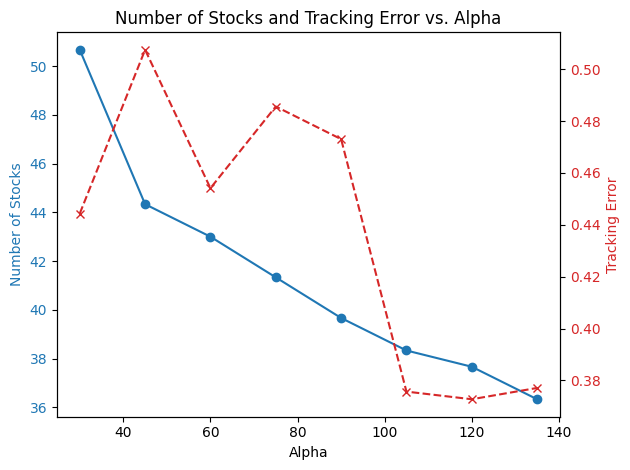

In [14]:
X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

alphas = [30, 45, 60, 75, 90, 105, 120, 135]
tracking_errors = []
num_stocks_list = []

for alpha in alphas:
    _, num_stocks, tracking_err = Lasso_Lasso(alpha, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)

print(num_stocks_list, tracking_errors)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Number of Stocks', color=color)
ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for tracking error
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
ax2.plot(alphas, tracking_errors, color=color, marker='x', linestyle='--', label='Tracking Error')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and legend
plt.title('Number of Stocks and Tracking Error vs. Alpha')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Mutual Info - Lasso
Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [15]:
def MI_feature_selection(X, y, tscv):
    mi_scores_accumulated = np.zeros(X.shape[1])
    for train_index, val_index in tscv.split(X):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        
        # Calculate MI scores for the training fold
        mi_scores = mutual_info_regression(X_train, y_train)
        
        # Accumulate MI scores
        mi_scores_accumulated += mi_scores
    
    # Step 3: Calculate the average MI score across folds
    average_mi_scores = mi_scores_accumulated / num_folds
    
    # Step 4: Select features based on the average MI score
    threshold = 0.1  # Adjust threshold as needed
    selected_features = X.columns[average_mi_scores > threshold]


In [16]:
def MI_Lasso(alpha, X, y):
    tscv = TimeSeriesSplit(n_splits=3)
    lasso_cv = LassoCV(alphas=[alpha], cv=tscv, max_iter=10000, random_state=42)
    lasso_cv.fit(X, y)

    # Get selected features    
    selector = SelectFromModel(lasso_cv, threshold=0.05, max_features=None)  # Adjust threshold as needed
    X_selected = selector.transform(X)
    selected_features = np.where(selector.get_support())[0] 
    X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=X.columns[selected_features])
    print(f"Selected {len(selected_features)} stocks")

    alphas = [0.1, 0.5, 1, 5, 10]
    best_alpha = None
    best_score = np.inf  # Initialize with a high value, so any result will be better
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        fold_scores = []  # Store the tracking error for each fold

        # Loop over each fold in the TimeSeriesSplit
        for train_index, test_index in tscv.split(X_selected_df):
            X_train_cv, X_test_cv = X_selected_df.iloc[train_index], X_selected_df.iloc[test_index]
            y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the Lasso model on the training data
            lasso.fit(X_train_cv, y_train_cv)
            
            # Predict on the test data
            y_pred = lasso.predict(X_test_cv)
    
            # Evaluate the model using the custom metric (e.g., tracking error)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            fold_scores.append(fold_score)
        
        # Calculate the average score across all folds
        average_score = np.mean(fold_scores)
        
        # Print the tracking error for this alpha
        print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
    
        # Track the best alpha (with the lowest tracking error)
        if average_score < best_score:
            best_score = average_score
            best_alpha = alpha
    
    print(f"\nBest Alpha: {best_alpha} with Tracking Error: {best_score}")    
    return len(selected_features), best_score

# Random Forest

In [17]:
def train_random_forest(tscv, depth, samples, estimators, X, y):
    rf = RandomForestRegressor(max_features="log2", max_depth=depth, min_samples_split=samples, n_estimators=estimators, random_state=42)
    scores = []
    importances = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Fit Lasso model on the training data
        rf.fit(X_train_cv, y_train_cv)
        
        # Get feature importance scores
        importances.append(rf.feature_importances_)
        
        # Get predictions and calculate the custom score for this fold
        y_pred = rf.predict(X_test_cv)
        fold_score = tracking_error(y_test_cv.values, y_pred)  # Replace with your custom metric
        print(f"Fold Score {fold_score}")
        scores.append(fold_score)
    
    # Calculate the average coefficients across all folds
    average_importances = np.mean(importances, axis=0)
    
    # Calculate the average score across all folds
    average_score = np.mean(scores)

    selected_stocks = np.where(abs(average_importances) > 1e-5)[0]

    print(len(np.where(abs(average_importances) == 0.0)[0]))

    print(selected_stocks)

    print("-------Avg Scores-------")
    print(f"CV Score: {average_score}")
    print(f"Number of Stocks: {len(selected_stocks)}")

    return (selected_stocks, average_score)

In [18]:
X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

tscv = TimeSeriesSplit(n_splits=3)

#train_random_forest(tscv, 2, 5, 15, X, y)

X = df_total.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total['NIFTY_100']

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'n_estimators': [15, 20, 25, 30, 35],
    'max_depth': [2, 3, 4],
    'min_samples_split': [5, 10, 15, 20]
}

results = []

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for samples in param_grid['min_samples_split']:
            (stocks, err) = train_random_forest(tscv, max_depth, samples, n_estimators, X, y)
            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': samples,
                'tracking_error': err,
                'num_selected_stocks': len(stocks)
            })


with open("/kaggle/working/rf_results.json", "w") as file:
    json.dump(results, file, indent=4)  # `indent=4` for pretty formatting

For the random forest model, only models with a very low number of estimators (n_estimators) 10 - 20, achieve feature selection, but those models probably suffer from high variance and won't be good enough to generalize. 

## Gradient Boosting

### XGBoost

In [19]:
def train_xgboost(tscv, X, y):
    xgbr = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=2,
        min_child_weight=5,
        gamma=5,
        subsample=0.5,
        colsample_bytree=0.3,
        alpha=100,
        learning_rate=0.1,
        random_state=42
    )

    scores = []
    importances = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        
        # Fit XGBR model on the training data
        xgbr.fit(X_train_cv, y_train_cv)
        
        # Get predictions and calculate the custom score for this fold
        y_pred = xgbr.predict(X_test_cv)
        fold_score = tracking_error(y_test_cv.values, y_pred)  # Replace with your custom metric
        print(f"Fold Score {fold_score}")
        scores.append(fold_score)

        importances.append(xgbr.feature_importances_)

    # Calculate the average score across all folds
    average_score = np.mean(scores)
    average_importances = np.mean(importances, axis=0)

    selected_stocks = np.where(average_importances > 0.0)[0]
    num_zero_importance_stocks = len(np.where(average_importances == 0.0)[0])
    
    print("-------Avg Scores-------")
    print(f"CV Score: {average_score}")
    print(f"Number of Stocks: {len(selected_stocks)} - Number of 0 importance stocks {num_zero_importance_stocks}")


In [20]:
train_xgboost(tscv, X, y)

Fold Score 0.11451923678371398
Fold Score 0.2242370085460745
Fold Score 0.36494057358377446
-------Avg Scores-------
CV Score: 0.23456560630452097
Number of Stocks: 94 - Number of 0 importance stocks 5
